In [1]:
import contextily
import datetime
import functools
import glob
import geopandas
import json
import numpy
import os
import pandas
import scipy.integrate, scipy.interpolate
import tqdm.auto as tqdm

from matplotlib import pyplot

tqdm.tqdm.pandas()

/home/leaf/miniconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import lib

In [3]:
AXIS_COLORS = {
    "X": "red",
    "Y": "green",
    "Z": "blue"
}

UNIT_VECTORS = {
    "X": numpy.array([1, 0, 0]),
    "Y": numpy.array([0, 1, 0]),
    "Z": numpy.array([0, 0, 1])
}

TIME_COLUMN = "TIME"

In [4]:
labels = pandas.concat([pandas.read_csv(x) for x in glob.glob("./labels/*.csv")])
for time_column in ["START", "END"]:
    labels[time_column] = (labels[time_column] / 1000)

raw_data = pandas.concat([
    pandas.read_csv(part)
    for part in sorted(glob.glob("./data_2018/*/adxl*.csv"))
]).sort_values("TIME").reset_index(drop = True)

sj = lib.SubwayJoiner()

labeled_data = sj.label_data(raw_data, labels)\
    .sort_values("TIME").reset_index(drop = True)

df = labeled_data
df.sample(5)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["SAMPLE_ID"] = sample_id
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["LOCATION"] = row["LOCATION"]
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

TIME      X     Y      Z  SAMPLE_ID  \
1125759  1.529889e+09  10.00  0.39   0.67         30   
454780   1.529462e+09  10.47  0.27   0.31        175   
57178    1.529371e+09  10.59 -0.16   0.04        345   
344523   1.529460e+09  10.51 -0.59   0.04        150   
164451   1.529374e+09   1.84  0.59 -10.00        373   

                                           LOCATION STATUS  DIRECTION  
1125759  haymarket green to government center green   left          1  
454780    community college to north station orange   left          1  
57178          community college to sullivan square   left          1  
344523     haymarket orange to north station orange   left          0  
164451                state street blue to aquarium   left          0

# Preprocessing

## Preprocessing: split on breaks in order to reassign axes on a per-dataframe basis
The dataframe must be split every time the device is reattached to a vehicle and the axes must be reassigned for that particular configuration. In the annotations, a realignment occurs when there is a gap between the end of one annotation and the beginning of another annotation (verified visually using the editor UI).

In [5]:
time_diffs = labeled_data["TIME"].diff()
time_diffs.describe().round(3)

count    2132760.000
mean           0.408
std          238.451
min            0.003
25%            0.017
50%            0.017
75%            0.018
max       248999.717
Name: TIME, dtype: float64

The sampling rate of the vibration sensor is under a tenth of a second, so we should be able to properly identify breaks by looking for delays of over a second

In [6]:
def split_on_breaks(df, time_threshold, time_column = "TIME"):
    time_diffs = labeled_data[time_column].diff()
    jumps = (time_diffs > 1).replace(False, numpy.nan).dropna().index
    splits = []
    
    last = 0
    for jump in jumps:
        splits.append(df.iloc[last:jump])
        last = jump
    splits.append(df.iloc[last:])
    
    return splits

In [7]:
parts = split_on_breaks(labeled_data, 1)
len(parts)

47

## Preprocessing: filter to only parts that went through at least 3 different locations (e.g. stations or segments)
Parts with an insufficnet number of samples may have their axes reassigned incorrectly

In [8]:
MIN_LOCATIONS = 3

parts = [
    part
    for part in parts
    if (len(part["LOCATION"].unique()) >= MIN_LOCATIONS)
]
len(parts)

39

## Preprocessing: basicentric axis detection and reassignment

Before processing can be done, the axes of the ADXL345 must be aligned to the basicentric axes of the body.

<center><img src=nbstatic/basicentric_axes.png style="max-height:200px;"><br>Figure 1: Basicentric axes, from ISO 2631-1</center>

ISO 2631-1 defines the basicentric axes as follows:
* X axis: outward from the chest
* Y axis: outwards in the direction of the left sie of the body
* Z axis: upwards

Because we are only looking at the vector sum of root-mean-square accelerations in the three axes, the direction of the axes do not matter. Although the X and Y axes are interchangeable in the vector sum equation, we will still want to align these as much as we can in order to capture the full magnitude of accelerations in either axis.

The goal will be to align all of the axes as much as possible. The general approach will be as follows:
1. Detect the Z axis by finding which axis has a median that is closest to $g$, the acceleration due to gravity. The positive direction is negative the sign of the median.
2. Detect the Y axis by finding which axis switches between positive and negative to a greater degree and for larger amounts of time, indicating acceleration and braking. This should be the remaining axis with the greater standard deviation after smoothing. The direction can be checked by comparing the time position of the maximum value of a segment to the time position of the minimum value.
3. The remaining axis is the X axis. The direction will be the cross product of unit vectors in the Y and Z axes.

For #2, we will use a finite state machine that reads sliding window data.

Using the graph above, we can deduce the following information, which will be used to test our detection algorithms:
* Positive basicentric Z axis: -X
* Positive basicentric Y axis: +Z
* Positive basicentric X axis: +Y

In [9]:
Y_AXIS_DIRECTION_DETECTION_WINDOW = 10 # seconds

def smoothed_axis_stds(
    df, time_column = TIME_COLUMN,
    period = "%ds" % Y_AXIS_DIRECTION_DETECTION_WINDOW
):
    df_temp = df.copy()
    df_temp.index = pandas.to_datetime(df_temp["TIME"], unit = "s")
    rolling = df_temp.rolling(period).mean()
    results = {}
    for axis in "XYZ":
        results[axis] = rolling[axis].std()
    return results

# Align the axres to the correct basicentric axes
def reassign_axes(
    df, orig_x = "X", orig_y = "Y", orig_z = "Z",
    y_axis_direction_detection_window = Y_AXIS_DIRECTION_DETECTION_WINDOW
):
    axes = [orig_x, orig_y, orig_z]
    axes_remaining = set(axes)
    
    ### Detection of Z axis
    (z_axis, z_median) = max(
        [(axis, df[axis].median()) for axis in axes],
        key = lambda x: abs(x[1])
    )
    axes_remaining.remove(z_axis)
    
    ### Detection of Z direction
    if (z_median > 0):
        z_sign = -1
    else:
        z_sign = 1
    
    ### Detection of Y axis
    (y_axis, _) = max(
        smoothed_axis_stds(df).items(),
        key = lambda x: x[1]
    )
    axes_remaining.remove(y_axis)
    
    ### Detection of Y direction
    y_sign = 0
    y_stds = df.groupby("SAMPLE_ID")[y_axis].std().sort_values().reset_index()
    
    # Loop over the n/2 periods with the largest standard deviation, where
    # n refers to the number of unique sample IDs. These samples are assumed
    # to be samples where the train is in motion.
    for sample_id in y_stds.iloc[-int(len(y_stds)/2):]["SAMPLE_ID"]:
        # If the median value of the first k samples when the data is sorted by
        # time is higher than the median value of the last k samples, then we
        # cast a vote that the positive direction aligns with the positive
        # basicentric direction. Otherwise, we cast a vote that the negative
        # direction aligns with the positive basicentric direction.
        df_sorted = df[df["SAMPLE_ID"] == sample_id][[TIME_COLUMN, y_axis]]
        times = df_sorted[TIME_COLUMN]
        median_start_value = df_sorted[
            times < times.min() + y_axis_direction_detection_window
        ][y_axis].median()
        median_end_value = df_sorted[
            times > times.max() - y_axis_direction_detection_window
        ][y_axis].median()

        if (median_start_value > median_end_value):
            y_sign += 1
        else:
            y_sign -= 1

    y_sign = numpy.sign(y_sign)
    
    # Detection of X axis
    x_axis = next(iter(axes_remaining))

    # Detection of X direction
    x_sign = numpy.cross(
        UNIT_VECTORS[z_axis] * z_sign,
        UNIT_VECTORS[y_axis] * y_sign
    ).sum()
    
    # Reassignment
    df_new = df.copy()
    df_new["X"] = df[x_axis] * x_sign
    df_new["Y"] = df[y_axis] * y_sign
    df_new["Z"] = df[z_axis] * z_sign
    
    return df_new

In [10]:
parts = [
    reassign_axes(part)
    for part in tqdm.tqdm(parts)
]

### Visual confirmation of axis reassignment

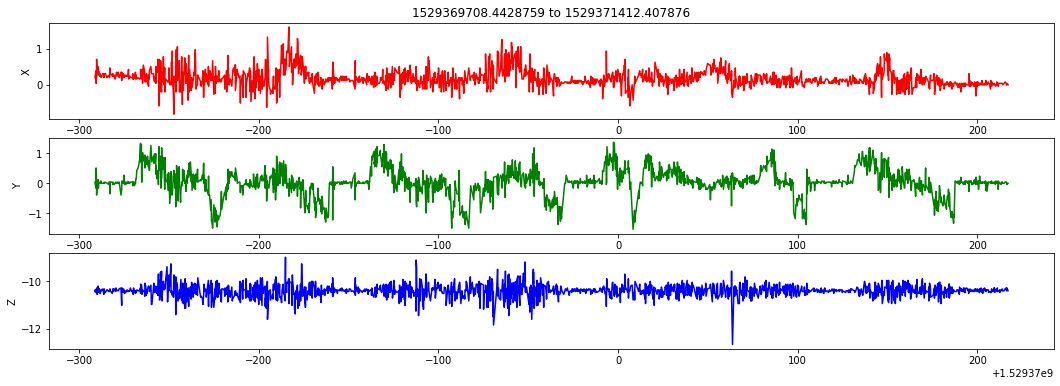

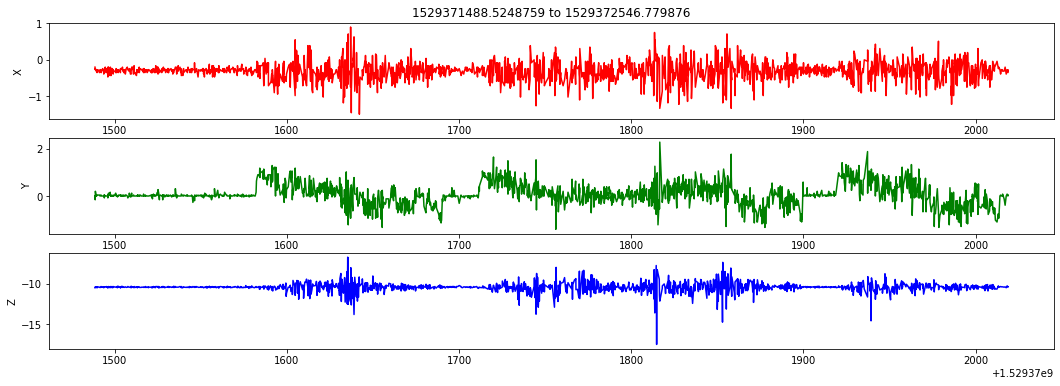

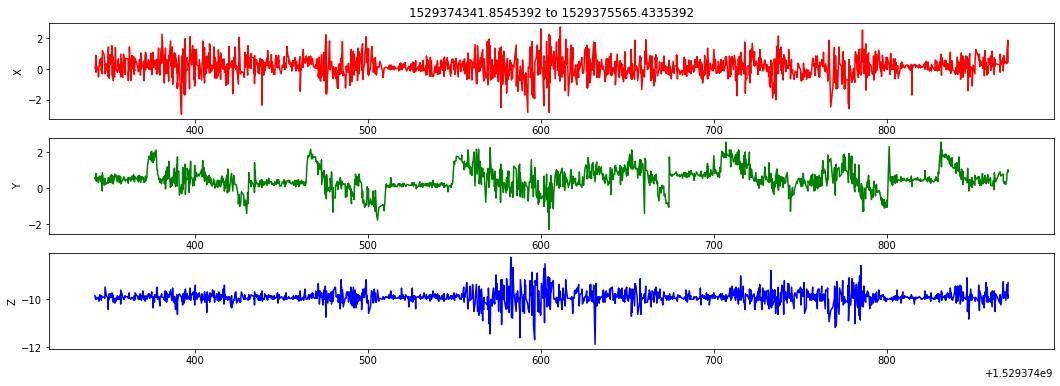

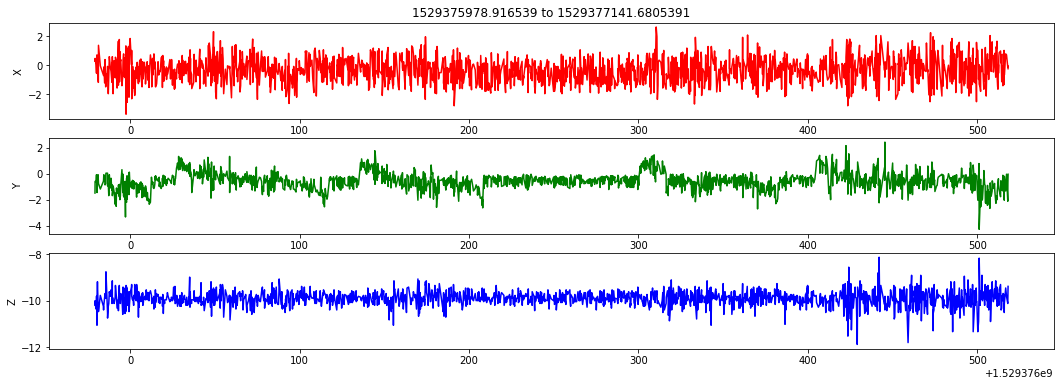

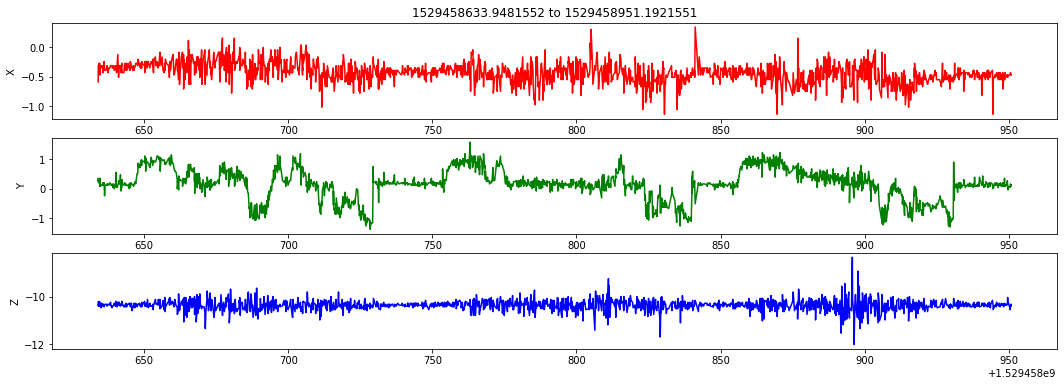

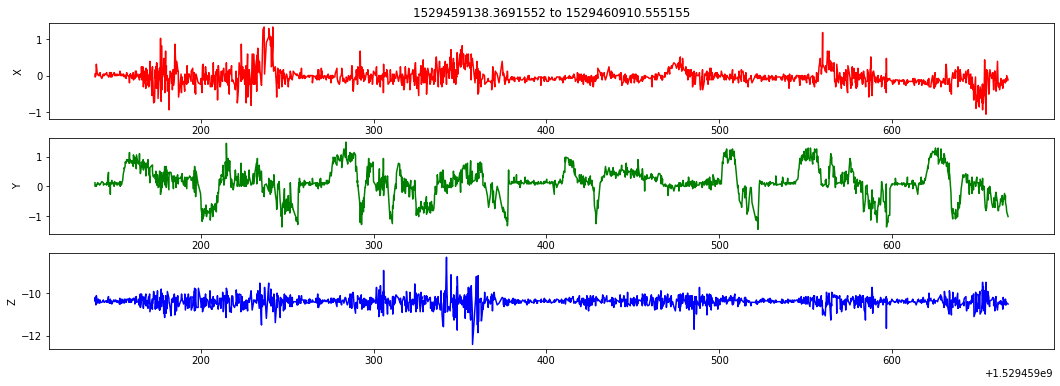

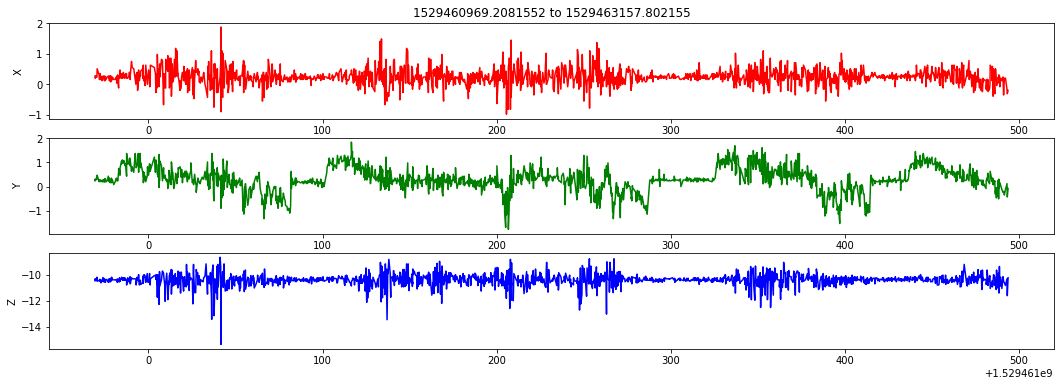

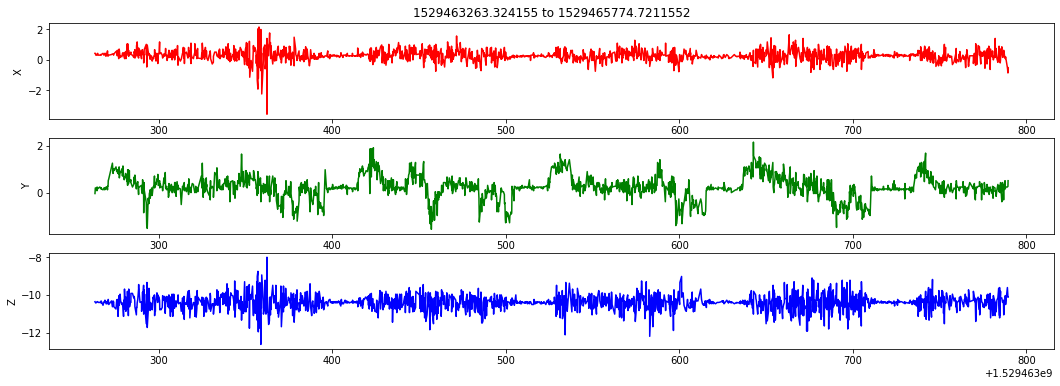

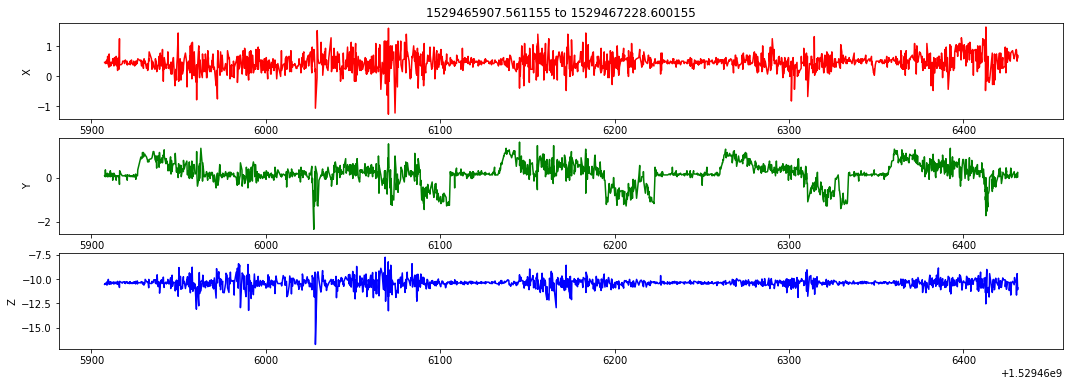

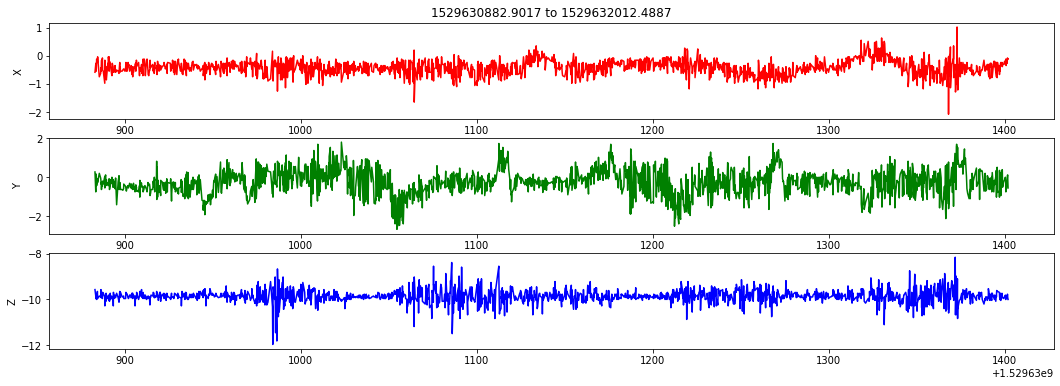

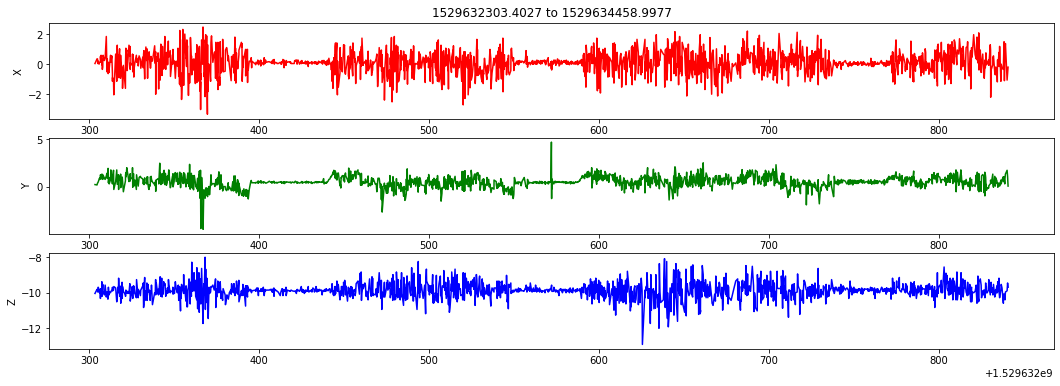

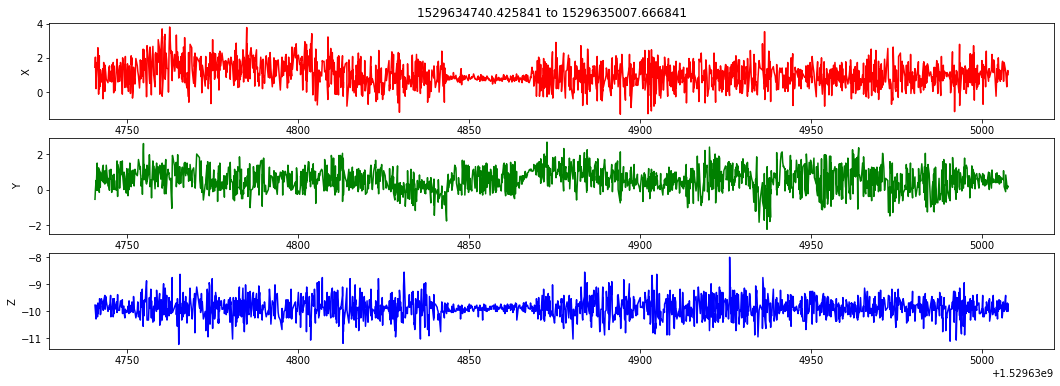

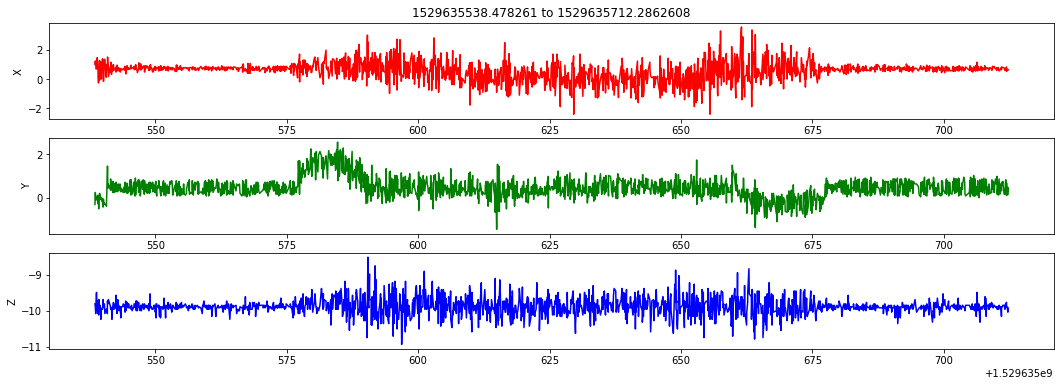

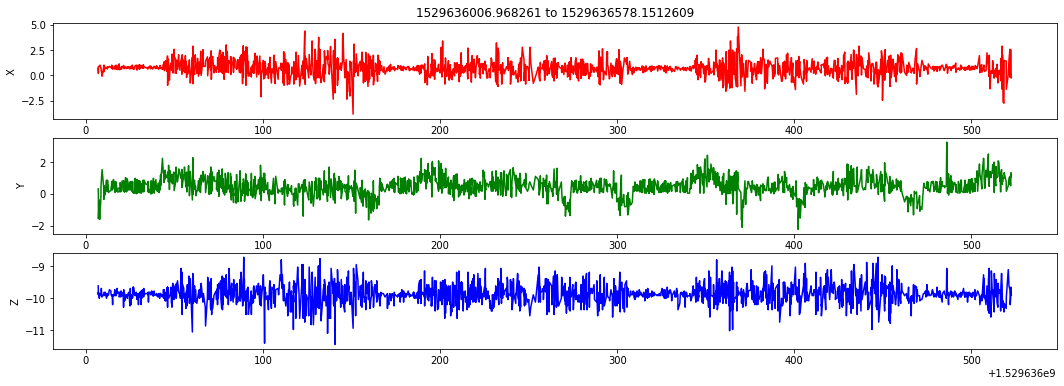

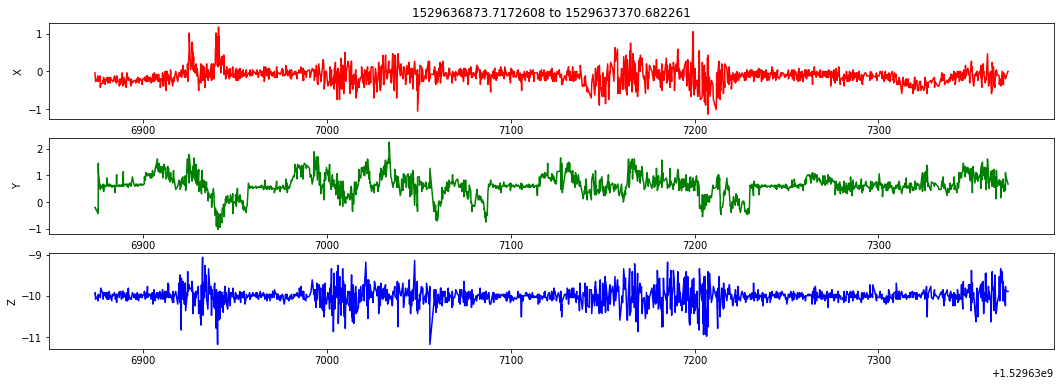

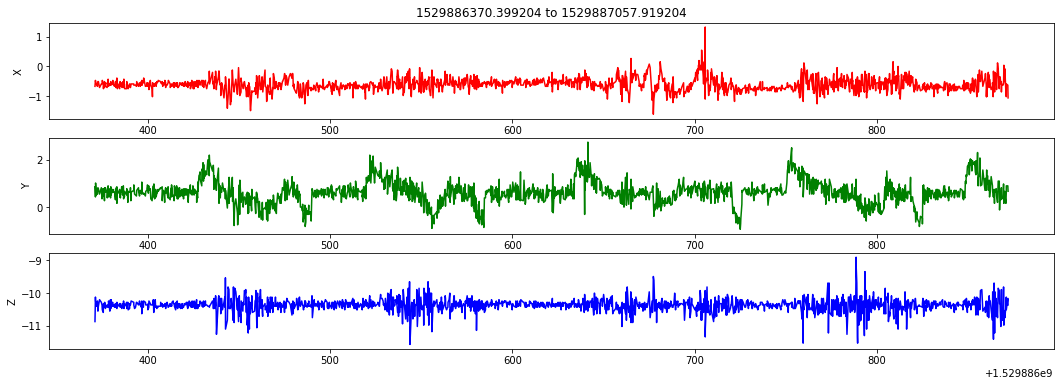

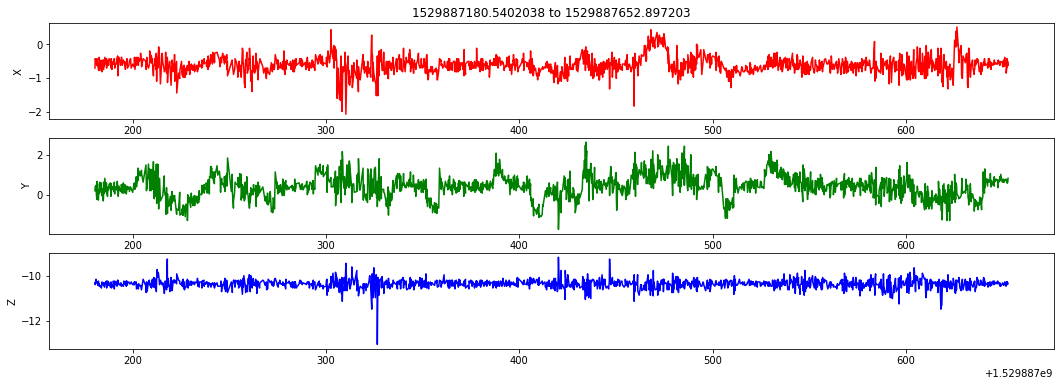

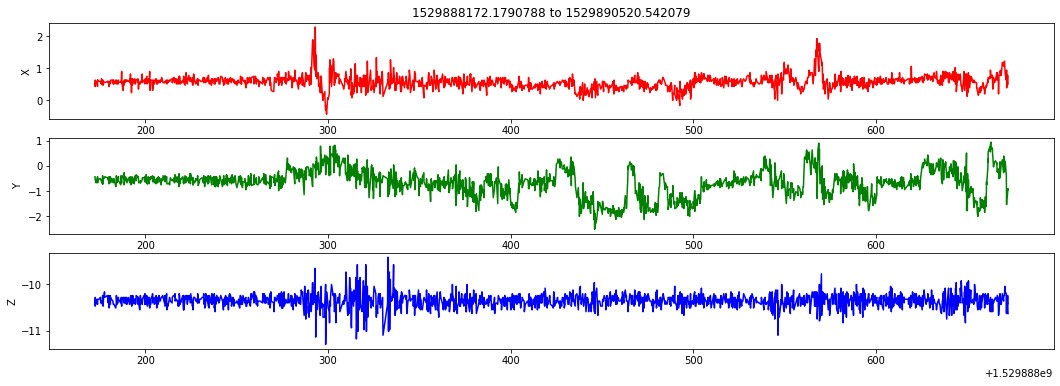

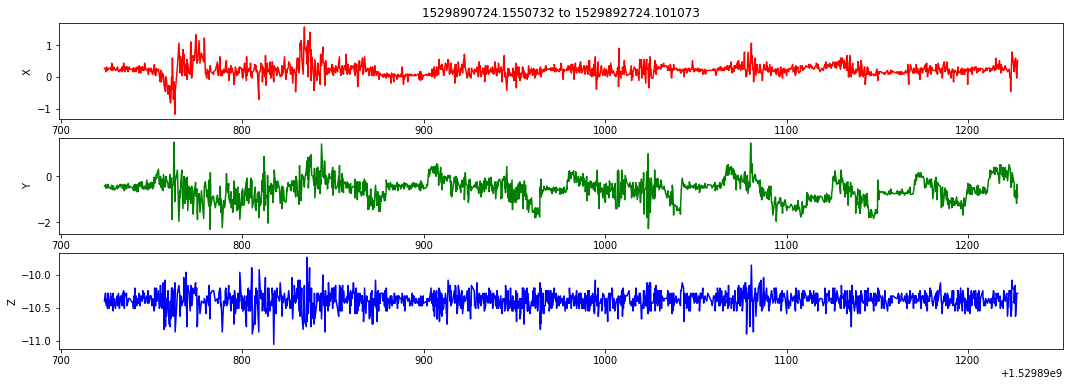

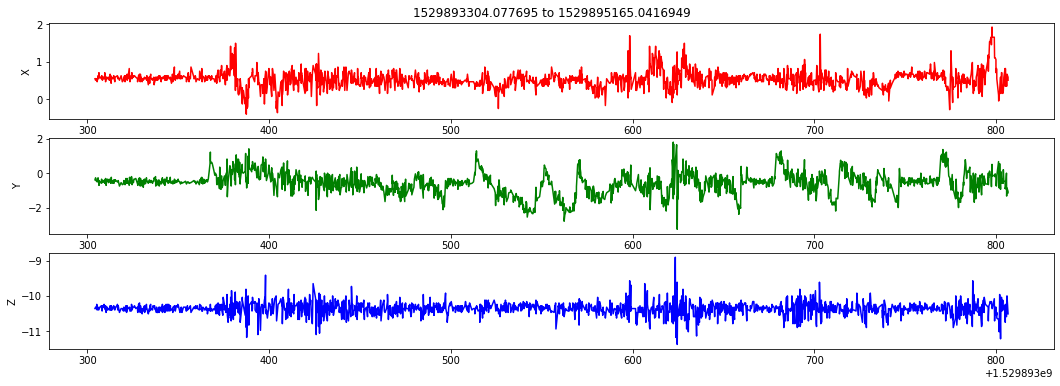

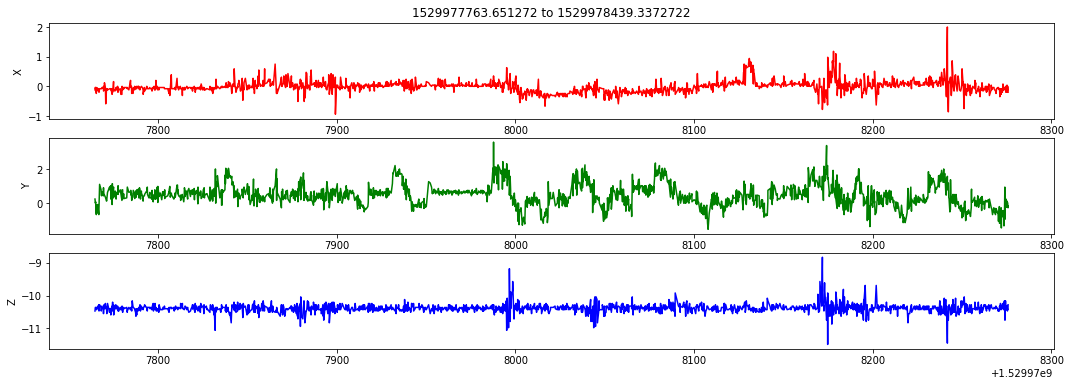

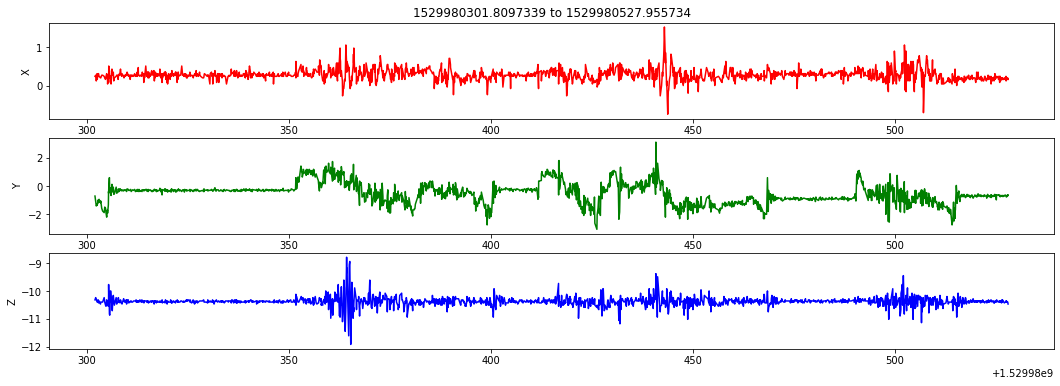

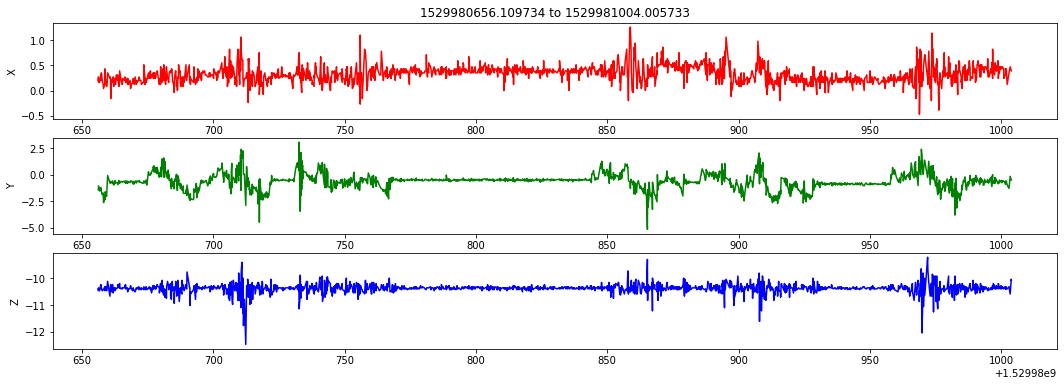

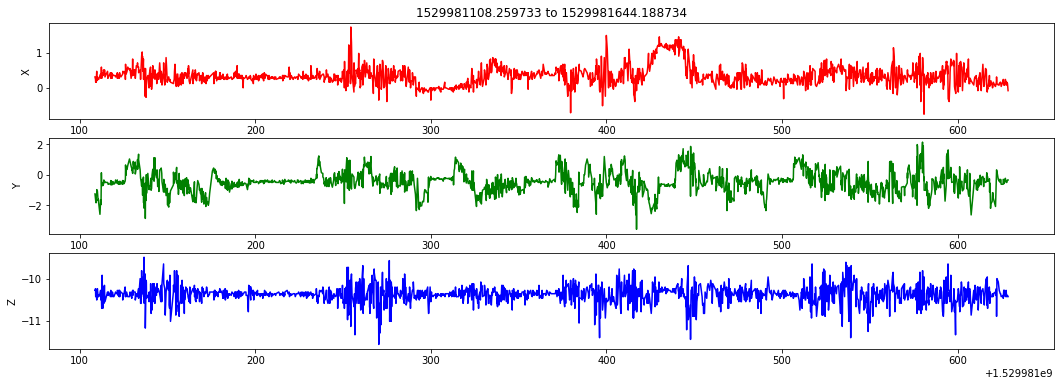

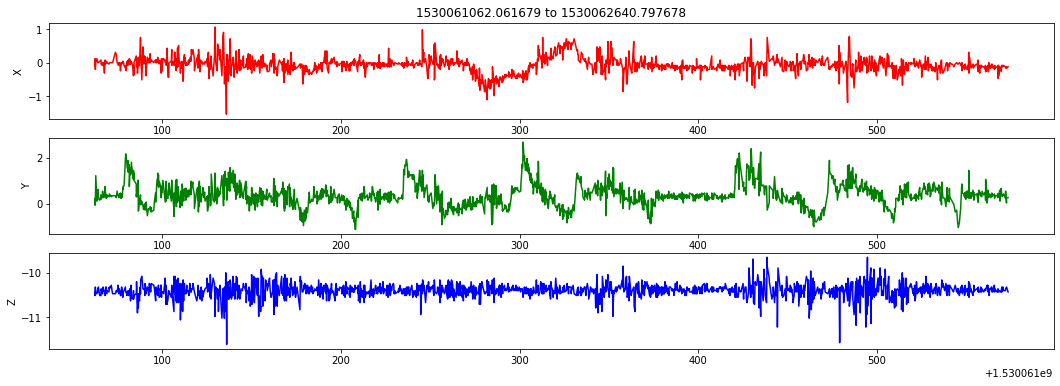

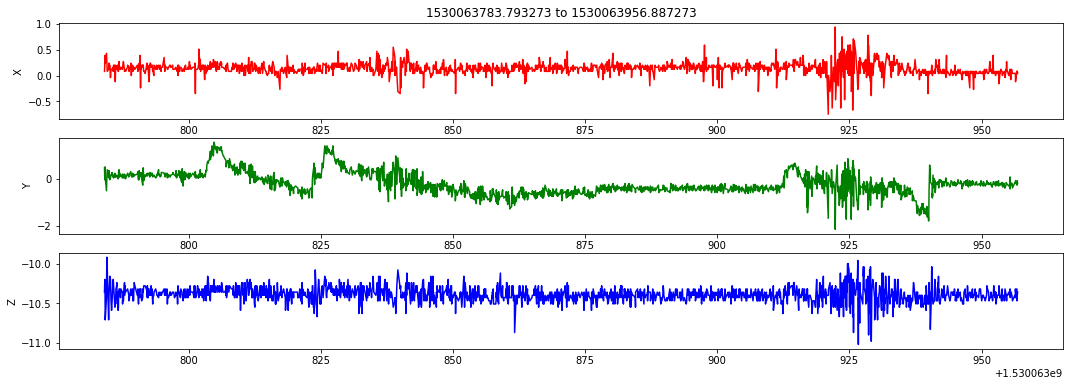

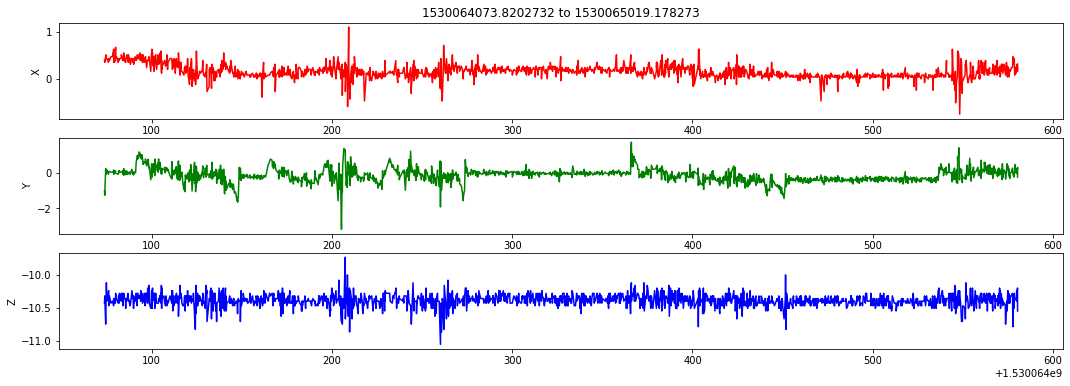

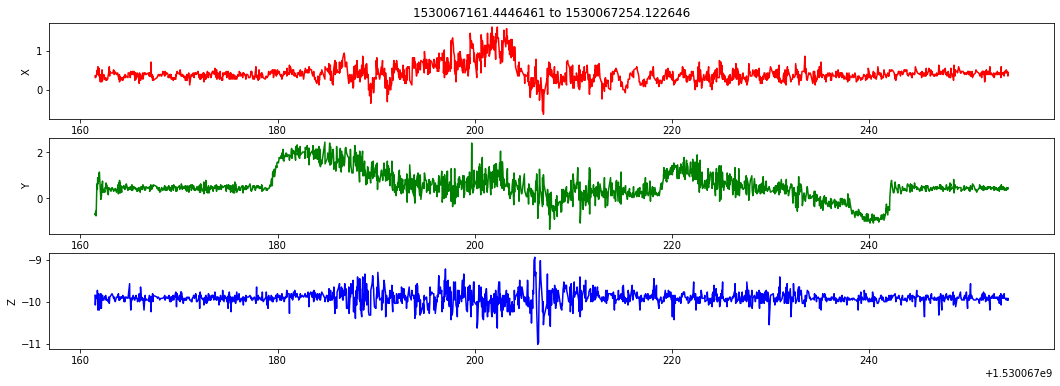

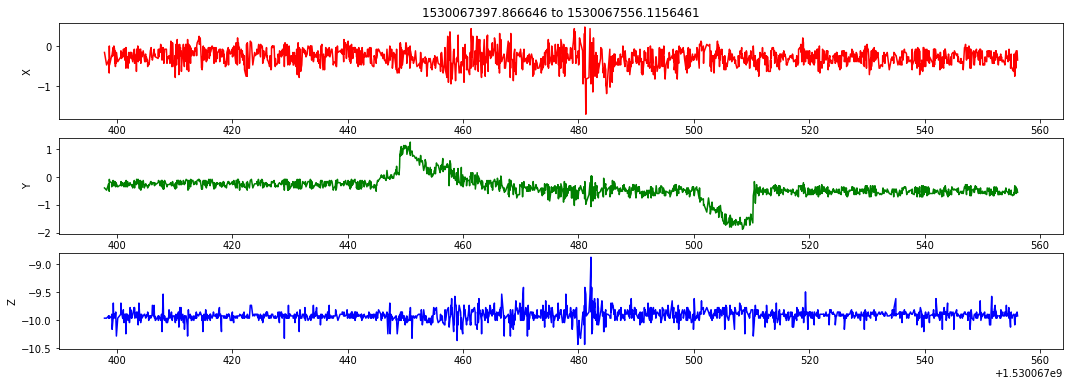

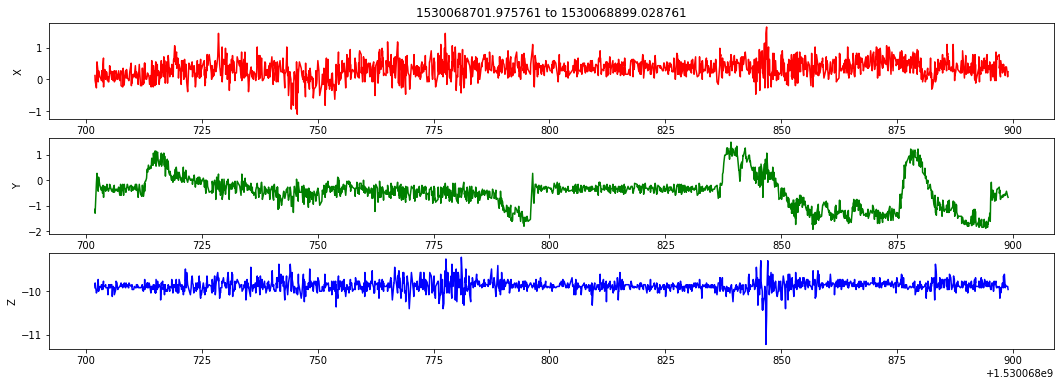

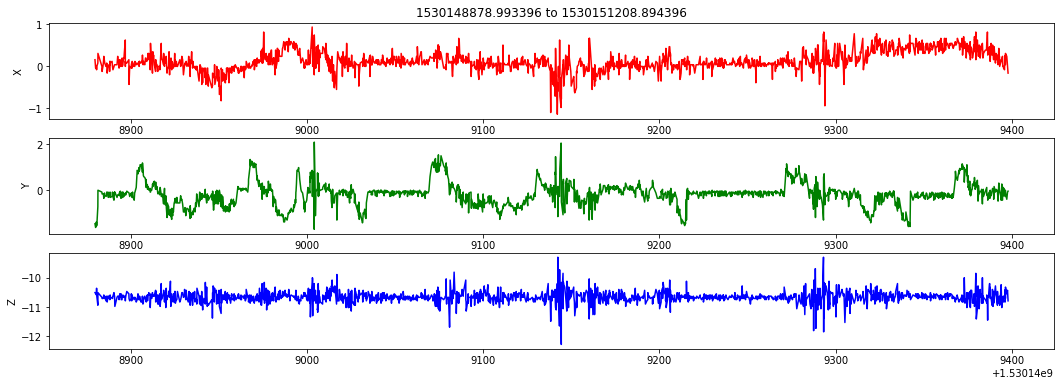

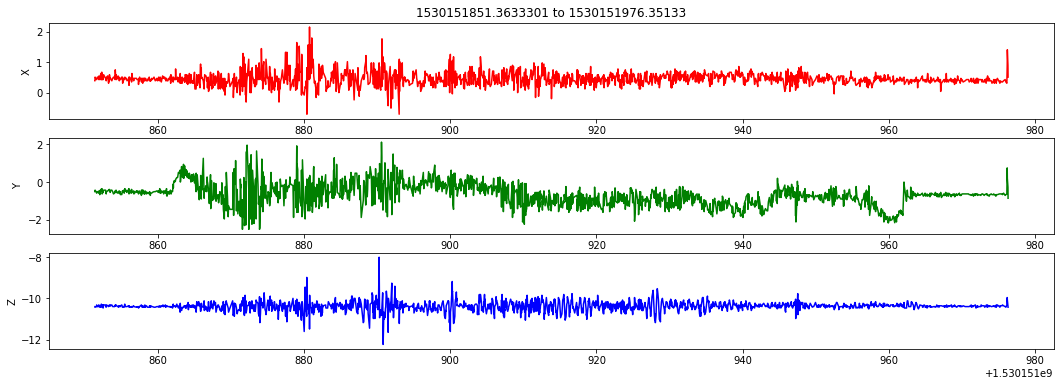

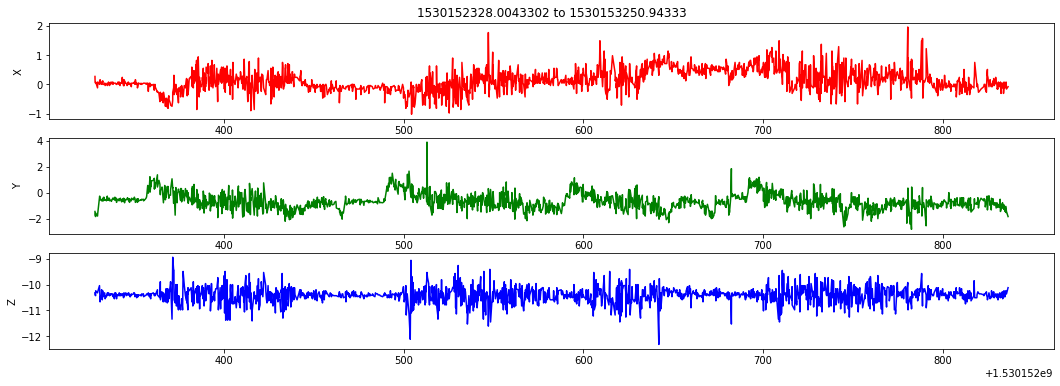

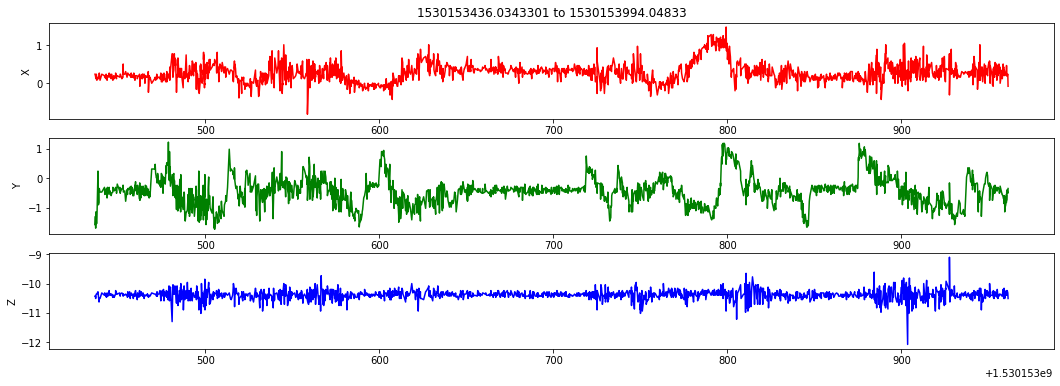

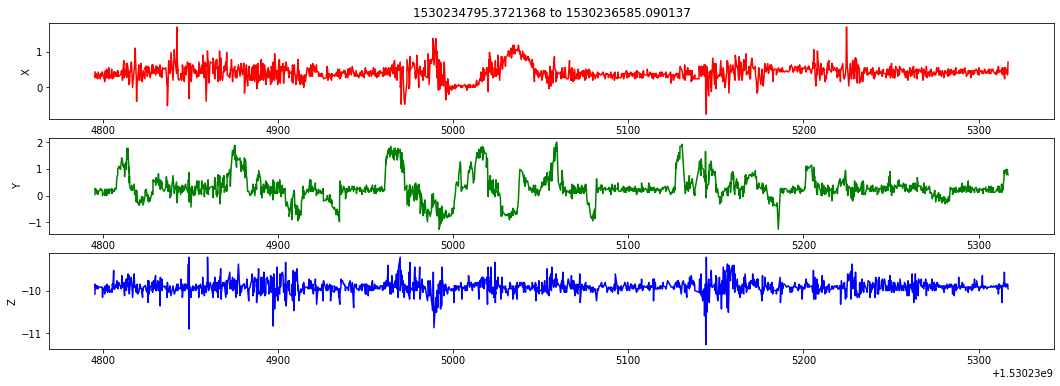

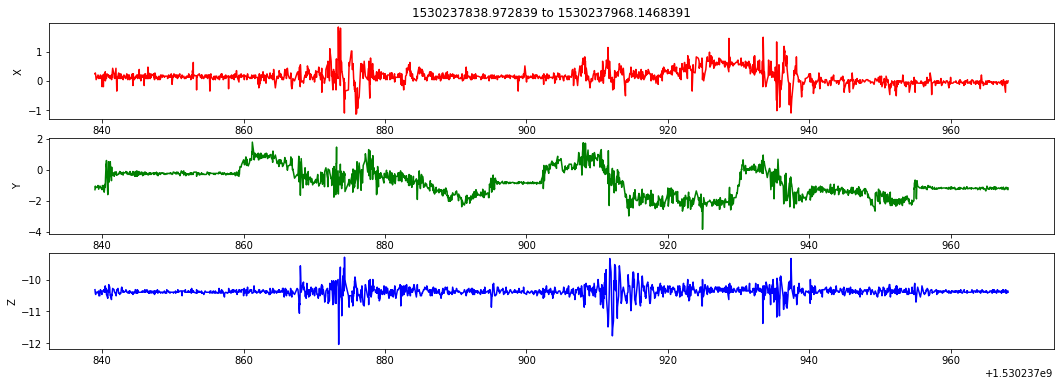

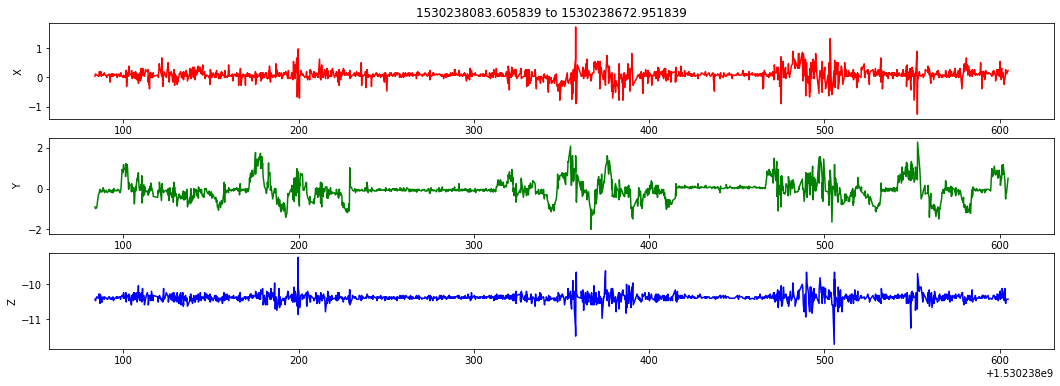

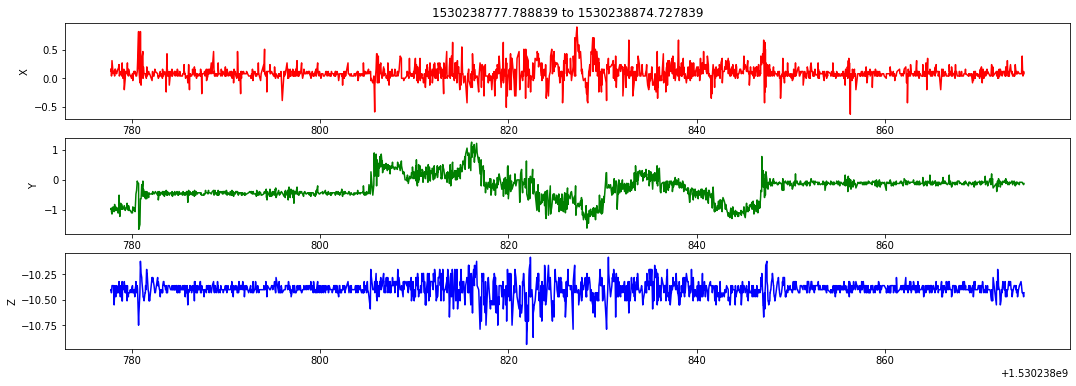

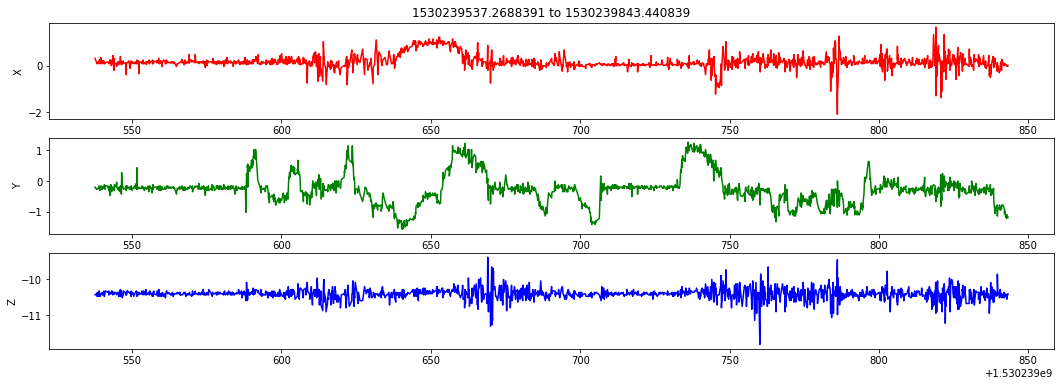

In [11]:
AXIS_COLORS = {
    "X": "red",
    "Y": "green",
    "Z": "blue"
}
AXES = "XYZ"

for part in parts:
    df_plot = part.iloc[:30000].sample(2000).sort_values("TIME")
    (figure, axes) = pyplot.subplots(3, 1, figsize = (18, 6))
    for i in range(len(AXES)):
        axis_name = AXES[i]
        axes[i].plot(df_plot["TIME"], df_plot[axis_name], c = AXIS_COLORS[axis_name])
        axes[i].set_ylabel(axis_name)
    axes[0].set_title("%s to %s" % (part["TIME"].min(), part["TIME"].max()))
    pyplot.show()
    pyplot.close()

# Preprocessing: normalizing the Z axis
The Z axis can be naively normalized by adding 9.8m/s<sup>2</sup>, the inverse of the acceleration due to gravity. However, due to errors in the device as well as small and subtle drifts in the orientation of the sensor, the correction is both larger than 9.8m/s<sup>2</sup> and slightly changes over time.

To correct this, we take the inverse of the mean of Z-axis readings during idle periods to be the correction factor for those periods. The correction factor for moving periods, which is where it is assumed that drift occurs as opposed to idle periods, is computed by linearly interpolating the mean Z-axis readings of adjacent idle periods.

In [12]:
def find_nearest_idle_section(sample_dfs, from_i, direction):
    j = from_i
    while True:
        j = j + direction
        if (j < 0) or (j > (len(sample_dfs)) + 1):
            return # out of range, nothing found
        else:
            df = sample_dfs[j]
            if df["STATUS"].iloc[0] == "stopped":
                return df

def normalize_z_axis(df):
    corrected_dfs = []
    
    # split dataframe into several new dataframes, one for each time the
    # sample ID changes
    sample_dfs = [
        df.loc[indices]
        for indices in df.groupby("SAMPLE_ID").groups.values()
    ]
    
    for (i, df_sample) in enumerate(sample_dfs):
        status = df_sample["STATUS"].iloc[0]

        # idle sections: subtract the mean value
        if status == "stopped":
            df_new = df_sample.copy()
            df_new["Z"] -= df_new["Z"].mean()
            corrected_dfs.append(df_new)

        # moving sections: interpolate the mean values of adjacent idle
        # sections. if not immediately sandwiched between idle sections, the
        # code will search for the nearest one.
        elif (i-1 >= 0) and (i+1 < len(sample_dfs)):
            
            # find previous idle section
            df_prev = find_nearest_idle_section(sample_dfs, i, -1)
            df_next = find_nearest_idle_section(sample_dfs, i, 1)
            if (df_prev is not None) and (df_next is not None):
                df_new = df_sample.copy()
                df_new["Z"] -= df_new[TIME_COLUMN].apply(
                    scipy.interpolate.interp1d(
                        [df_prev[TIME_COLUMN].max(), df_next[TIME_COLUMN].min()],
                        [df_prev["Z"].mean(), df_next["Z"].mean()]
                    )
                )
                corrected_dfs.append(df_new)
    
    return pandas.concat(corrected_dfs)

### test to confirm that the algorithm is working as intended

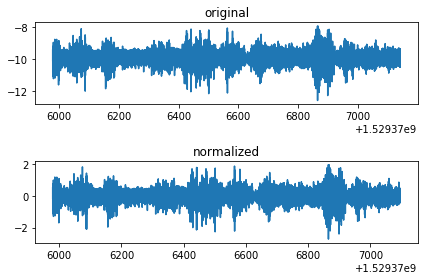

In [13]:
# this has a time period with 2 consecutive moving sections; good test for the
# idle section search function
p = parts[3].copy()

(figure, axes) = pyplot.subplots(2, 1)
for (axis, df, title) in zip(
        axes,
        [p, normalize_z_axis(p)],
        ["original", "normalized"]
    ):
    axis.plot(df["TIME"], df["Z"])
    axis.set_title(title)
pyplot.tight_layout()

In [14]:
parts = [
    normalize_z_axis(part)
    for part in tqdm.tqdm(parts)
]

# Preprocessing: concatenate parts and convert units from m/s<sup>2</sup> to mm/s<sup>2</sup>

In [15]:
df_all = pandas.concat(parts)
for axis in "XYZ":
    df_all[axis] = df_all[axis] * 1000

# Analysis

In [16]:
ADXL345_AGGREGATES = {
    "X": ["mean", "median", "std", "count"],
    "Y": ["mean", "median", "std"],
    "Z": ["mean", "median", "std"]
}

In [17]:
(stations, segments) = sj.geospatial_join(df_all)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[0])
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[1])


Root-mean-square acceleration, from ISO 2631-1(1997):
$$
    a_w = \sqrt{\frac{1}{T}\int^T_0{a^2_w(t)dt}}
$$
Vector sum acceleration, also from ISO 2631-1(1997):
$$
    a_{w,\sum} = \sqrt{
        (1.4a_{w,x})^2
        + (1.4a_{w,y})^2
        + a_{w,z}^2
    }
$$

In [18]:
def a_rms(acceleration_data, time_data):
    duration = time_data.max() - time_data.min()
    return (
        scipy.integrate.trapz(acceleration_data**2, time_data) / duration
    )**0.5

def concat_readings(df):
    """ Concatenate different vibration readings, in order to prepare for
    calculating the root-mean-square.
    
    Args:
        df: A DataFrame containing all data for a specific track segment.
    
    Returns:
        A DataFrame with all vibration data for the given track segment
        concatenated end-to-end, with timestamps starting at 0.
    """

    parts = []
    for (i, indices) in enumerate(df.groupby("SAMPLE_ID").groups.values()):
        df_group = df.loc[indices]
        
        # adjust timestamps to start at 0, to simplify things
        # this doesn't affect the calculations since we use only use the
        # time between readings - not the absolute time - for calculations
        df_group["TIME"] = df_group["TIME"] - df_group["TIME"].min()
        
        # for each reading, adjust the timestamps to start starts x seconds
        # after the previous reading ends, where x is mean time between
        # samples in the previous reading
        if len(parts) > 0:
            previous = parts[i-1]
            df_group["TIME"] = (
                df_group["TIME"]
                + previous["TIME"].max()
                + previous["TIME"].diff().mean()
            )
        
        parts.append(df_group)
    return pandas.concat(parts)

def aggregate(df):
    segment_data = concat_readings(df)
    sums = (
        (1.4 * segment_data["X"].abs())**2
        + (1.4 * segment_data["Y"].abs())**2
        + (segment_data["Z"].abs())**2
    )**0.5
    return pandas.Series({
        "VECTOR_SUM.rms": a_rms(sums, segment_data["TIME"]),
        "VECTOR_SUM.25pctile": sums.quantile(0.25),
        "VECTOR_SUM.75pctile": sums.quantile(0.75),
        "VECTOR_SUM.count": len(segment_data)
    })

# create aggregates and export
groupby_columns = ["START_STATION", "END_STATION", "ROUTE", "LINE"]
segment_aggregates_directionless = segments.groupby(groupby_columns)\
    .progress_apply(aggregate).reset_index()
segment_aggregates_directionless.melt(groupby_columns)\
    .to_csv("output/segments/directionless/vibration.csv", index=False)

groupby_columns = ["START_STATION", "END_STATION", "ROUTE", "DIRECTION", "LINE"]
segment_aggregates = segments.groupby(groupby_columns)\
    .progress_apply(aggregate).reset_index()
segment_aggregates.melt(groupby_columns)\
    .to_csv("output/segments/by_direction/vibration.csv", index=False)

In [19]:
import importlib
lib = importlib.reload(lib)
segments["RMS"] = (
    (1.4 * segments["X"].abs())**2
    + (1.4 * segments["Y"].abs())**2
    + (segments["Z"].abs())**2
)**0.5
lib.export_webapp_histograms(
    None, segments, "RMS", "vibration", 30
)

In [20]:
# aggregation is very different from the other quantities so we have to export
# the data and metadata manually

quantity = "vibration"

for_webapp = pandas.concat([
    segment_aggregates, segment_aggregates_directionless
]).rename({
    "VECTOR_SUM.rms": "center",
    "VECTOR_SUM.75pctile": "upper",
    "VECTOR_SUM.25pctile": "lower"
}, axis=1)
for_webapp.to_csv("output/webapp/segments/{}.csv".format(quantity), index=False)

# save metadata
if os.path.isfile("output/webapp/metadata.json"):
    with open("output/webapp/metadata.json", "r") as f:
        all_metadata = json.load(f)
else:
    all_metadata = {}
all_metadata[quantity] = {
    "axis": "Vector Sum Vibration [mm/s²]",
    "selection": "vibration",
    "center_desc": "Root-mean-square",
    "variability_desc": "Quantiles",
    "colormap": "magma"
}
with open("output/webapp/metadata.json", "w") as f:
    json.dump(all_metadata, f, indent=4)

for_webapp

START_STATION       END_STATION              ROUTE  DIRECTION  \
0              Airport       Wood Island               Blue        0.0   
1              Airport       Wood Island               Blue        1.0   
2       Allston Street     Griggs Street                  B        0.0   
3       Allston Street     Griggs Street                  B        1.0   
4               Andrew          Broadway  Ashmont/Braintree        0.0   
..                 ...               ...                ...        ...   
98   Washington Square  Fairbanks Street                  C        NaN   
99   Washington Street     Warren Street                  B        NaN   
100         Wellington     Malden Center             Orange        NaN   
101        Wood Island    Orient Heights               Blue        NaN   
102           Woodland             Waban                  D        NaN   

       LINE       center        lower        upper  VECTOR_SUM.count  
0      Blue  1451.224647   746.686260  1742.497956            4727.0  
1      Blue  1826.519586  1096.871258  2142.367195            4292.0  
2     Green   670.979366   287.469671   758.876883            3715.0  
3     Green  1052.185124   301.646782  1288.760146            2510.0  
4       Red  1765.111755  1036.008590  2040.858754            7159.0  
..      ...          ...          ...          ...               ...  
98    Green  1178.771589   346.067127  1248.541670            7648.0  
99    Green  1583.349931   667.778146  1948.819098           11106.0  
100  Orange  1077.443223   525.159789  1210.422335           70528.0  
101    Blue  1747.753787   917.720049  2041.896733           14513.0  
102   Green  1022.513181   694.981435  1156.851718            7255.0  

[286 rows x 9 columns]